https://anderfernandez.com/blog/como-poner-modelo-de-python-en-produccion/

# Cómo poner un modelo de Python en Producción

In [9]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import math

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.metrics import mean_absolute_error  
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Fast API
# ==============================================================================
from fastapi import FastAPI

## Tratamiento de datos

In [10]:
# Download data
# ==============================================================================
url = 'https://raw.githubusercontent.com/anderfernandez/datasets/main/Casas%20Madrid/houses_Madrid.csv'
data = pd.read_csv(url )
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    21742 non-null  int64  
 1   id                            21742 non-null  int64  
 2   title                         21742 non-null  object 
 3   subtitle                      21742 non-null  object 
 4   sq_mt_built                   21616 non-null  float64
 5   sq_mt_useful                  8228 non-null   float64
 6   n_rooms                       21742 non-null  int64  
 7   n_bathrooms                   21726 non-null  float64
 8   n_floors                      1437 non-null   float64
 9   sq_mt_allotment               1432 non-null   float64
 10  latitude                      0 non-null      float64
 11  longitude                     0 non-null      float64
 12  raw_address                   16277 non-null  object 
 13  i

In [11]:
# Valores texto con un único valor
# ==============================================================================
str_cols = data.select_dtypes(['object']).columns
str_unique_vals = data[str_cols]\
    .apply(lambda x: len(x.dropna().unique()))

str_unique_vals

title                           10736
subtitle                          146
raw_address                      9666
street_name                      6177
street_number                     420
floor                              19
is_floor_under                      2
neighborhood_id                   126
operation                           1
house_type_id                       4
is_new_development                  2
has_central_heating                 2
has_individual_heating              2
has_ac                              1
has_fitted_wardrobes                1
has_lift                            2
is_exterior                         2
has_garden                          1
has_pool                            1
has_terrace                         1
has_balcony                         1
has_storage_room                    1
is_accessible                       1
has_green_zones                     1
energy_certificate                 10
is_parking_included_in_price        2
is_orientati

In [12]:
# Cambiar NaNs por False
# ==============================================================================
str_unique_vals_cols = str_unique_vals[str_unique_vals == 1].index.tolist()

data.loc[:,str_unique_vals_cols] = data\
  .loc[:,str_unique_vals_cols].fillna(False)

# Elimino variables con mucho NA
ind_keep = data.isna().sum() < 0.3 * data.shape[0]
data = data.loc[:,ind_keep]

# Remove columns
data.drop([
  'title', 'street_name','raw_address',
  'is_exact_address_hidden','is_rent_price_known',
  'is_buy_price_known', 'subtitle',
  'floor','buy_price_by_area', 'rent_price', 'id', 'Unnamed: 0'
  ], axis = 1, inplace = True)

C:\Users\jaesc2\AppData\Local\Temp\ipykernel_21068\1114518348.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,str_unique_vals_cols] = data\


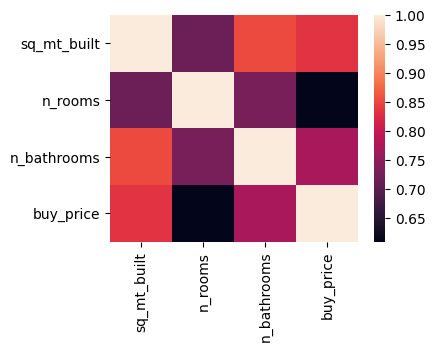

In [13]:
# Heatmap Numéricas
# ==============================================================================

# Cambio el tamaño
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.dpi'] = 100

str_cols = data.select_dtypes('object').columns.tolist()
num_cols = data.select_dtypes(['int', 'float']).columns.tolist()

# Selecciono datos numéricos
cor_matrix = pd.concat([data[num_cols]], axis = 1).corr()
sns.heatmap(cor_matrix)
plt.show()

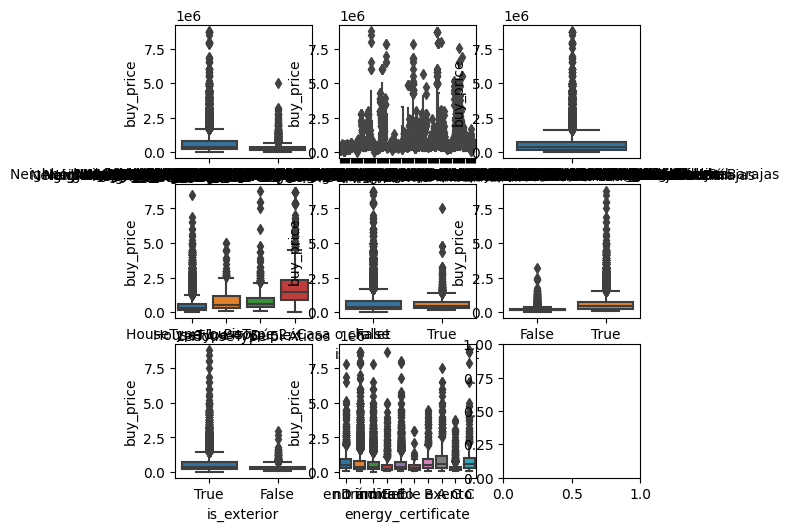

In [14]:
# Variables Categóricas
# ==============================================================================
str_cols = data.select_dtypes('object').columns

fig, ax = plt.subplots(math.ceil(len(str_cols)/3), 3, figsize=(6, 6))

for var, subplot in zip(str_cols, ax.flatten()):
    sns.boxplot(x=var, y='buy_price', data=data, ax=subplot)

plt.show()

Visualmente, podemos ver como el tipo de vivienda (house_type_id) tiene unas diferencias bastante marcadas, al igual que el hecho de que tenga o no ascendor (has_lift). Aunque habría formas mejores de comprobarlo, para este ejemplo nos sirve con esto.

## Creación del Modelo de predicción del precio de la vivienda

In [15]:
# Train-test split
# ==============================================================================
keep_cols = ['sq_mt_built', 'n_bathrooms', 'n_rooms' , 'has_lift', 'house_type_id']

# Split de los datos
y = data['buy_price']
x = data[keep_cols]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 1234)

print(x_train.shape, y_train.shape)

(16306, 5) (16306,)


In [16]:
# Check NaNs
# ==============================================================================
print(x_train.isna().sum())
x_train\
  .assign(
      n_nas = x_train['has_lift'].isnull(),
      n_rows = 1
      )\
  .groupby('house_type_id')\
  .sum()\
  .reset_index()\
  .loc[:,['house_type_id', 'n_nas', 'n_rows']]


sq_mt_built        98
n_bathrooms        10
n_rooms             0
has_lift         1828
house_type_id     286
dtype: int64


C:\Users\jaesc2\AppData\Local\Temp\ipykernel_21068\2839069436.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x_train\


,house_type_id,n_nas,n_rows
0,HouseType 1: Pisos,312,13260
1,HouseType 2: Casa o chalet,1496,1496
2,HouseType 4: Dúplex,7,502
3,HouseType 5: Áticos,5,762


In [17]:
# Transformo en train y test
x_train.loc[
            x_train['house_type_id'] == 'HouseType 2: Casa o chalet', 'has_lift'
            ] = False

x_test.loc[
            x_test['house_type_id'] == 'HouseType 2: Casa o chalet', 'has_lift'
            ] = False

print(x_train.isna().sum())

sq_mt_built       98
n_bathrooms       10
n_rooms            0
has_lift         332
house_type_id    286
dtype: int64


In [18]:
# Imputo NAs con la moda
import pickle

# Calculo las modas
modes = dict(zip(x_train.columns, x_train.mode().loc[0,:].tolist()))

# Imputo la moda
for column in x_train.columns:
  x_train.loc[x_train[column].isna(),column] = modes.get(column)

In [19]:
# Defino el encoder
encoder = LabelBinarizer()
encoder_fit = encoder.fit(x_train['house_type_id'])

encoded_data_train = pd.DataFrame(
  encoder_fit.transform(x_train['house_type_id']),
  columns = encoder_fit.classes_.tolist()
) 

# Add encoded variables
x_train_transf = pd.concat(
  [x_train.reset_index(), encoded_data_train],
  axis = 1
  )\
  .drop(['index', 'house_type_id'], axis = 1)

# Create model
rf_reg = RandomForestRegressor()
rf_reg_fit = rf_reg\
  .fit(x_train_transf, y_train)

preds = rf_reg_fit.predict(x_train_transf)

print('Train error:', mean_absolute_error(y_train, preds))

Train error: 115372.91074353029


In [20]:
# Imputo la moda
for column in x_test.columns:
  x_test.loc[x_test[column].isna(),column] = modes.get(column)

# One hot encoding
encoded_data_test = pd.DataFrame(
  encoder_fit.transform(x_test['house_type_id']),
  columns = encoder_fit.classes_.tolist()
) 

x_test_transf = pd.concat(
  [x_test.reset_index(), encoded_data_test],
  axis = 1
  )\
  .drop(['index','house_type_id'], axis = 1)

preds = rf_reg_fit.predict(x_test_transf)

print('Test error:', mean_absolute_error(y_test, preds))

Test error: 180108.13740147935


## Crear API

In [22]:
# Almacenar encoder y model
# ==============================================================================
with open(r'./app/encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(r'./app/model.pickle', 'wb') as handle:
    pickle.dump(rf_reg_fit, handle, protocol=pickle.HIGHEST_PROTOCOL)

lanzar API desde carpeta app:

uvicorn main:app --reload

## Generar predicción

Una vez levantada la API...

In [1]:
sq_met = 100
n_bathrooms = 2
n_rooms = 2
has_lift = True
house_type = 'HouseType 1: Pisos'  

In [1]:
import requests

sq_met = 100
n_bathrooms = 2
n_rooms = 2
has_lift = True
house_type = 'HouseType 1: Pisos'  


url = (f'http://127.0.0.1:8000/make_preds?'
       f'sq_mt={sq_met}&'
       f'n_bathrooms={n_bathrooms}&'
       f'n_rooms={n_rooms}&'
       f'has_lift={has_lift}&'
       f'house_type={house_type}')

url = url.replace(' ', '20')

resp = requests.post(url)

resp.content

In [ ]:
url = f'http://127.0.0.1:8000/make_preds?sq_mt={sq_met}&n_bathrooms={n_bathrooms}&n_rooms={n_rooms}&has_lift={has_lift}&house_type={house_type}'

In [ ]:
http://127.0.0.1:8000/make_preds?sq_mt=100&n_bathrooms=2&n_rooms=2&has_lift=True&house_type='HouseType 1: Pisos'

In [3]:
print((f'http://127.0.0.1:8000/make_preds?'
       f'sq_mt={sq_met}&'
       f'n_bathrooms={n_bathrooms}&'
       f'n_rooms={n_rooms}&'
       f'has_lift={has_lift}&'
       f'house_type={house_type}').replace(' ', '20'))

http://127.0.0.1:8000/make_preds?sq_mt=100&n_bathrooms=2&n_rooms=2&has_lift=True&house_type=HouseType201:20Pisos
